<a href="https://colab.research.google.com/github/IgorShestov/pet-projects/blob/main/Test_Veraxen_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дано

У вас есть два мобильных приложения - A, B.
Каждое из них монетизируется рекламой (показывает своим пользователям
рекламу) двух типов: interstitial, banner. Вы зарабатываете деньги за показы
рекламы.


Каждый день команда user acquisition привлекает вам новых пользователей
(инсталлы) в приложения A и B посредством маркетинговых каналов P, Q, S.
У вас есть все данные о количестве показов interstitial и banner внутри A,B -
т.е. для каждого привлеченного пользователя вы знаете его приложение (A
или B), канал привлечения (P, Q или S), его страну, когда он был привлечен
в приложение, и знаете сколько ему было показано (кол-во показов -
interstitial, banner раздельно) рекламы внутри приложения за каждый\любой
день.


Одновременно с этим вам известно сколько вы получаете выручки за
каждую тысячу показов рекламы interstitial и banner (такая метрика
называется eCPM - effective cost per mile).
Синтетические данные представлены в .csv файлах

Задача

Рассчитать показатель кумулятивного ARPU (average revenue per user) для
каждой когорты для каждого дня, сформировать отчет, сделать возможные
выводы об эффективности, проанализировать особенности данных.

Рассматриваться будут подход, пути решения, код, визуализация и выводы.

https://docviewer.yandex.ru/view/401435006/?*=8sBJb1aNaPx056dOuu7%2BR1QX6Ul7InVybCI6InlhLW1haWw6Ly8xNzcwNDc3NjAzNTEwMDM4NjgvMS4yIiwidGl0bGUiOiJEQV9WRVJBWEVOX3Rlc3QuemlwIiwibm9pZnJhbWUiOmZhbHNlLCJ1aWQiOiI0MDE0MzUwMDYiLCJ0cyI6MTYzMTM1OTAwNDAwOSwieXUiOiI4NTAzODYwMzcxNTc3NjI0MzgwIn0%3D

In [ ]:
# подгружаем библиотеки
# основные
import pandas as pd 
import numpy as np


# работа со времинем
import datetime
from datetime import datetime
from datetime import timedelta

# статистика
from scipy import sparse
import scipy.stats as ss

# отображение
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

In [ ]:
# загружаем данные
aggr = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DF/Veraxen/ecpm_aggr.csv')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DF/Veraxen/events_data.csv')

Блок пред обратобки данных.

In [ ]:
aggr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6120 entries, 0 to 6119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6120 non-null   int64  
 1   ecpm_value  6120 non-null   float64
 2   date        6120 non-null   object 
 3   app         6120 non-null   object 
 4   country     6120 non-null   object 
 5   ecpm_type   6120 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 287.0+ KB


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835380 entries, 0 to 835379
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           835380 non-null  int64  
 1   date                 835380 non-null  object 
 2   app                  835380 non-null  object 
 3   version              835380 non-null  float64
 4   network              835380 non-null  object 
 5   event_type           835380 non-null  object 
 6   installs             835380 non-null  int64  
 7   days_after_installs  835380 non-null  int64  
 8   country              835380 non-null  object 
 9   events_amount        835380 non-null  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 63.7+ MB


In [ ]:
aggr.head(5)

,Unnamed: 0,ecpm_value,date,app,country,ecpm_type
0,0,0.757282,2021-06-04 13:30:27.883259,awesome app A,US,banner
1,1,0.788831,2021-06-05 13:30:27.883259,awesome app A,US,banner
2,2,0.796442,2021-06-06 13:30:27.883259,awesome app A,US,banner
3,3,0.807773,2021-06-07 13:30:27.883259,awesome app A,US,banner
4,4,0.747525,2021-06-08 13:30:27.883259,awesome app A,US,banner


In [ ]:
aggr.sample(5)

,Unnamed: 0,ecpm_value,date,app,country,ecpm_type
5544,54,8.656769,2021-07-28 13:30:27.883259,brilliant app B,ID,interstitial
6065,35,9.473233,2021-07-09 13:30:27.883259,brilliant app B,ES,interstitial
1249,79,10.996923,2021-08-22 13:30:27.883259,awesome app A,DE,interstitial
69,69,0.758726,2021-08-12 13:30:27.883259,awesome app A,US,banner
131,41,11.378557,2021-07-15 13:30:27.883259,awesome app A,US,interstitial


In [ ]:
data.head(5)

,Unnamed: 0,date,app,version,network,event_type,installs,days_after_installs,country,events_amount
0,0,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,0,US,757128.0
1,1,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,1,US,799973.0
2,2,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,2,US,655098.0
3,3,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,3,US,713709.0
4,4,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,4,US,588658.0


In [ ]:
data.sample(5)

,Unnamed: 0,date,app,version,network,event_type,installs,days_after_installs,country,events_amount
248979,9,2021-07-16 14:25:35.063117,awesome app A,1.1,AdNetwork P,interstitial,86800,9,IN,378233.0
383759,17,2021-08-03 14:25:35.063117,awesome app A,2.0,AdNetwork Q,banner,120571,17,GB,5282016.0
379978,15,2021-08-16 14:25:35.063117,awesome app A,2.0,AdNetwork P,banner,100668,15,IT,3940642.0
548443,19,2021-07-16 14:25:35.063117,brilliant app B,2.0,AdNetwork Q,banner,111722,19,RU,3797463.0
18430,54,2021-06-18 14:25:35.063117,awesome app A,1.0,AdNetwork P,banner,92778,54,RU,363773.0


In [ ]:
# все данные из колонки date переводим в таймстемп.
date_timestemp =pd.to_datetime(data.date, format="%Y-%m-%d")

In [ ]:
# создаю отдельный DataFrame для создания дат для набора данных data
DataFrame_data_dated = pd.DataFrame()
DataFrame_data_dated['day']= pd.to_datetime(data['date']) + data['days_after_installs'].map(timedelta)
DataFrame_data_dated['start_day']= pd.to_datetime(data['date']).dt.date
DataFrame_data_dated['actual_date'] = DataFrame_data_dated['day'].dt.date

In [ ]:
# проверяю на правильность выполнения
DataFrame_data_dated.head()

,day,start_day,actual_date
0,2021-06-30 14:25:35.063117,2021-06-30,2021-06-30
1,2021-07-01 14:25:35.063117,2021-06-30,2021-07-01
2,2021-07-02 14:25:35.063117,2021-06-30,2021-07-02
3,2021-07-03 14:25:35.063117,2021-06-30,2021-07-03
4,2021-07-04 14:25:35.063117,2021-06-30,2021-07-04


In [ ]:
# создаем новый dataframe объединяя 2 существующих
data_act = pd.concat([data , DataFrame_data_dated], axis=1)
# проверяю на правильность выполнения
data_act

,Unnamed: 0,date,app,version,network,event_type,installs,days_after_installs,country,events_amount,day,start_day,actual_date
0,0,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,0,US,757128.0,2021-06-30 14:25:35.063117,2021-06-30,2021-06-30
1,1,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,1,US,799973.0,2021-07-01 14:25:35.063117,2021-06-30,2021-07-01
2,2,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,2,US,655098.0,2021-07-02 14:25:35.063117,2021-06-30,2021-07-02
3,3,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,3,US,713709.0,2021-07-03 14:25:35.063117,2021-06-30,2021-07-03
4,4,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,4,US,588658.0,2021-07-04 14:25:35.063117,2021-06-30,2021-07-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835375,39,2021-07-20 14:25:35.063117,brilliant app B,2.2,AdNetwork S,banner,72281,39,ES,1125075.0,2021-08-28 14:25:35.063117,2021-07-20,2021-08-28
835376,40,2021-07-20 14:25:35.063117,brilliant app B,2.2,AdNetwork S,banner,72281,40,ES,1366665.0,2021-08-29 14:25:35.063117,2021-07-20,2021-08-29
835377,41,2021-07-20 14:25:35.063117,brilliant app B,2.2,AdNetwork S,banner,72281,41,ES,1069572.0,2021-08-30 14:25:35.063117,2021-07-20,2021-08-30
835378,42,2021-07-20 14:25:35.063117,brilliant app B,2.2,AdNetwork S,banner,72281,42,ES,1354628.0,2021-08-31 14:25:35.063117,2021-07-20,2021-08-31


In [ ]:
# повторяю для aggr
DataFrame_aggr_dated = pd.DataFrame()
DataFrame_aggr_dated['actual_date'] = pd.to_datetime(aggr['date']).dt.date

In [ ]:
# проверяю на правильность выполнения
DataFrame_aggr_dated.head()

,actual_date
0,2021-06-04
1,2021-06-05
2,2021-06-06
3,2021-06-07
4,2021-06-08


In [ ]:
# создаем новый dataframe объединяя 2 существующих
aggr_act = pd.concat([aggr , DataFrame_aggr_dated], axis=1)
# проверяю на правильность выполнения
aggr_act.head()

,Unnamed: 0,ecpm_value,date,app,country,ecpm_type,actual_date
0,0,0.757282,2021-06-04 13:30:27.883259,awesome app A,US,banner,2021-06-04
1,1,0.788831,2021-06-05 13:30:27.883259,awesome app A,US,banner,2021-06-05
2,2,0.796442,2021-06-06 13:30:27.883259,awesome app A,US,banner,2021-06-06
3,3,0.807773,2021-06-07 13:30:27.883259,awesome app A,US,banner,2021-06-07
4,4,0.747525,2021-06-08 13:30:27.883259,awesome app A,US,banner,2021-06-08


In [ ]:
aggr_act.drop(columns=['Unnamed: 0', 'date'], inplace=True)
aggr_act.rename(columns={"ecpm_type": "event_type"},inplace=True)

In [2]:
# проверяю на правильность выполнения
aggr_act

NameError: ignored

In [ ]:
# соединяем 2 таблицы в одну 
data_m =data_act.merge(aggr_act, how='outer')

In [ ]:
# проверяем правильность выполнения
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835380 entries, 0 to 835379
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Unnamed: 0           835380 non-null  int64         
 1   date                 835380 non-null  object        
 2   app                  835380 non-null  object        
 3   version              835380 non-null  float64       
 4   network              835380 non-null  object        
 5   event_type           835380 non-null  object        
 6   installs             835380 non-null  int64         
 7   days_after_installs  835380 non-null  int64         
 8   country              835380 non-null  object        
 9   events_amount        835380 non-null  float64       
 10  day                  835380 non-null  datetime64[ns]
 11  start_day            835380 non-null  object        
 12  actual_date          835380 non-null  object        
 13  ecpm_value    

In [ ]:
# расчитываем показатель ARPU
data_m['ARPU']= ( data_m.ecpm_value * data_m.events_amount / 1000 ) / data_m.installs

In [ ]:
# проверяем правильность выполнения
data_m

,Unnamed: 0,date,app,version,network,event_type,installs,days_after_installs,country,events_amount,day,start_day,actual_date,ecpm_value,ARPU
0,0,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,0,US,757128.0,2021-06-30 14:25:35.063117,2021-06-30,2021-06-30,11.344681,0.089569
1,1,2021-06-29 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95792,1,US,635731.0,2021-06-30 14:25:35.063117,2021-06-29,2021-06-30,11.344681,0.075290
2,2,2021-06-28 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95542,2,US,624999.0,2021-06-30 14:25:35.063117,2021-06-28,2021-06-30,11.344681,0.074213
3,3,2021-06-27 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95896,3,US,675012.0,2021-06-30 14:25:35.063117,2021-06-27,2021-06-30,11.344681,0.079855
4,4,2021-06-26 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,96081,4,US,466941.0,2021-06-30 14:25:35.063117,2021-06-26,2021-06-30,11.344681,0.055134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835375,0,2021-06-04 14:25:35.063117,brilliant app B,2.0,AdNetwork Q,interstitial,95799,0,ES,757579.0,2021-06-04 14:25:35.063117,2021-06-04,2021-06-04,9.162330,0.072456
835376,0,2021-06-04 14:25:35.063117,brilliant app B,2.0,AdNetwork S,interstitial,72177,0,ES,402619.0,2021-06-04 14:25:35.063117,2021-06-04,2021-06-04,9.162330,0.051109
835377,0,2021-06-04 14:25:35.063117,brilliant app B,2.0,AdNetwork P,banner,79904,0,ES,9730042.0,2021-06-04 14:25:35.063117,2021-06-04,2021-06-04,0.616927,0.075124
835378,0,2021-06-04 14:25:35.063117,brilliant app B,2.0,AdNetwork Q,banner,95799,0,ES,15161626.0,2021-06-04 14:25:35.063117,2021-06-04,2021-06-04,0.616927,0.097638


In [ ]:
data_m['Unnamed: 0'].max()


89

In [ ]:
# бред
x=1
y=1
while x<89:
  x+=1
  y+=x
print(y)

4005


Сделать ветвь для расчетов cumulative_ARPU.


позволит строить ежедневные графики для каждой кагорты.

In [ ]:
# cоздаем магию=) 
# Вычисляем сумму ARPU идругих показателей, для каждой уникальной группы "кагорты".
data_m_s = data_m.groupby(['app', 'version', 'network', 'event_type', 'country']).sum().reset_index()

In [ ]:
# проверяем правильность выполнения
data_m_s

,app,version,network,event_type,country,start_day,Unnamed: 0,installs,days_after_installs,events_amount,ecpm_value,ARPU
0,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-04,4005,7459740,4005,228247335.0,55.962285,1.710515
1,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-05,3916,7367064,3916,180125551.0,55.340090,1.352730
2,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-06,3828,7270912,3828,232954543.0,54.737277,1.754821
3,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-07,3741,7245708,3741,259669579.0,54.101750,1.935939
4,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-08,3655,7161736,3655,207683196.0,53.494440,1.552936
...,...,...,...,...,...,...,...,...,...,...,...,...
18355,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-28,10,437780,10,2763598.0,48.510467,0.305443
18356,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-29,6,351224,6,2020527.0,39.132114,0.224642
18357,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-30,3,264198,3,2302102.0,29.629671,0.257981
18358,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-31,1,176514,1,984365.0,19.963219,0.111376


In [ ]:
data_m_s.drop(columns=['Unnamed: 0',	'days_after_installs',	'events_amount',	'ecpm_value'], inplace=True)

In [ ]:
# проверяем правильность выполнения
data_m_s

,app,version,network,event_type,country,start_day,installs,events_amount,ecpm_value,ARPU
0,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-04,82886,228247335.0,55.962285,1.710515
1,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-05,82776,180125551.0,55.340090,1.352730
2,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-06,82624,232954543.0,54.737277,1.754821
3,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-07,83284,259669579.0,54.101750,1.935939
4,awesome app A,1.0,AdNetwork P,banner,AU,2021-06-08,83276,207683196.0,53.494440,1.552936
...,...,...,...,...,...,...,...,...,...,...
18355,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-28,87556,2763598.0,48.510467,0.305443
18356,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-29,87806,2020527.0,39.132114,0.224642
18357,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-30,88066,2302102.0,29.629671,0.257981
18358,brilliant app B,2.2,AdNetwork S,interstitial,VN,2021-08-31,88257,984365.0,19.963219,0.111376


In [ ]:
data_mfi[data_mfi.network=='AdNetwork P'].ARPU.sum()

6623.289882619077

In [ ]:
data_mfi[data_mfi.network=='AdNetwork Q'].ARPU.sum()

6619.463391728146

In [ ]:
data_mfi[data_mfi.network=='AdNetwork S'].ARPU.sum()

6630.215340627146

In [ ]:
data_mfi[data_mfi['app']=='brilliant app B'].ARPU.mean()

53.925200096824106

In [ ]:
data_mfi[data_mfi['app']=='awesome app A'].ARPU.mean()

28.99420848111845

In [ ]:
data_mfi[data_mfi['app']=='brilliant app B'].ARPU.sum()

11000.740819752118

In [ ]:
data_mfi[data_mfi['app']=='awesome app A'].ARPU.sum()

8872.227795222254

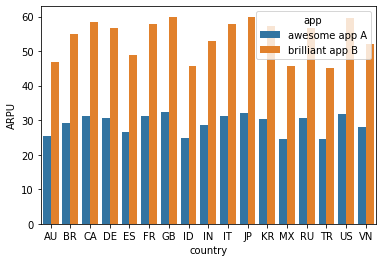

In [ ]:
sns.barplot(
    x="country", 
    y="ARPU", 
    hue="app", 
    ci=None,
    data=data_mfi
)

In [ ]:
data_mfi

,app,version,network,event_type,country,installs,ARPU
0,awesome app A,1.0,AdNetwork P,banner,AU,172321522,42.386495
1,awesome app A,1.0,AdNetwork P,banner,BR,168124657,48.719011
2,awesome app A,1.0,AdNetwork P,banner,CA,175106161,53.773344
3,awesome app A,1.0,AdNetwork P,banner,DE,172472942,49.260983
4,awesome app A,1.0,AdNetwork P,banner,ES,166412655,44.016556
...,...,...,...,...,...,...,...
505,brilliant app B,2.2,AdNetwork S,interstitial,MX,91061862,28.534970
506,brilliant app B,2.2,AdNetwork S,interstitial,RU,82822910,36.229642
507,brilliant app B,2.2,AdNetwork S,interstitial,TR,92476310,26.901084
508,brilliant app B,2.2,AdNetwork S,interstitial,US,85449786,38.130598


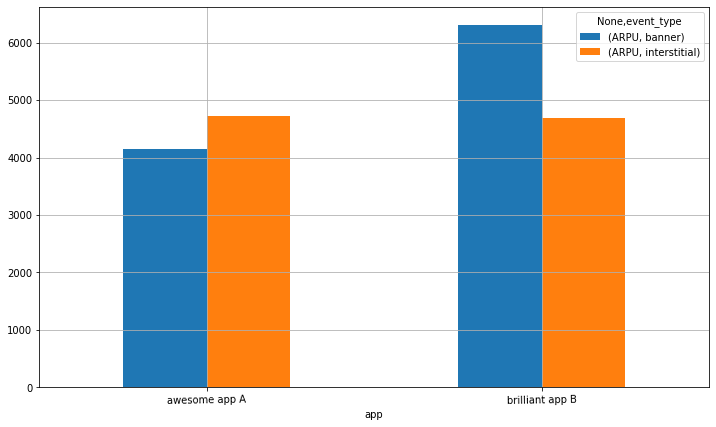

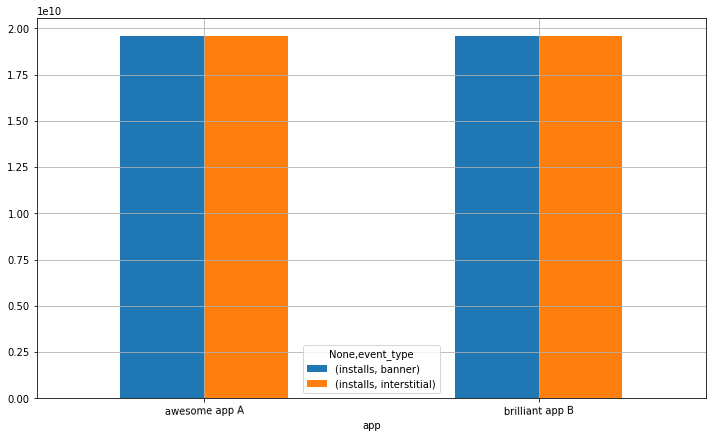

In [ ]:
pd.pivot_table(data_mfi,
              index = 'app',
              columns = ['event_type'],
              values = ['ARPU'],
              aggfunc = { 'ARPU'     :np.sum}
               ).plot(kind='bar',
                      figsize=(12,7), 
                      grid=True, 
                      sort_columns=False,
                      rot=1
                      )
pd.pivot_table(data_mfi,
              index = 'app',
              columns = ['event_type'],
              values = ['installs'],
              aggfunc = { 'installs'     :np.sum}
               ).plot(kind='bar',
                      figsize=(12,7), 
                      grid=True, 
                      sort_columns=False,
                      rot=1
                      )

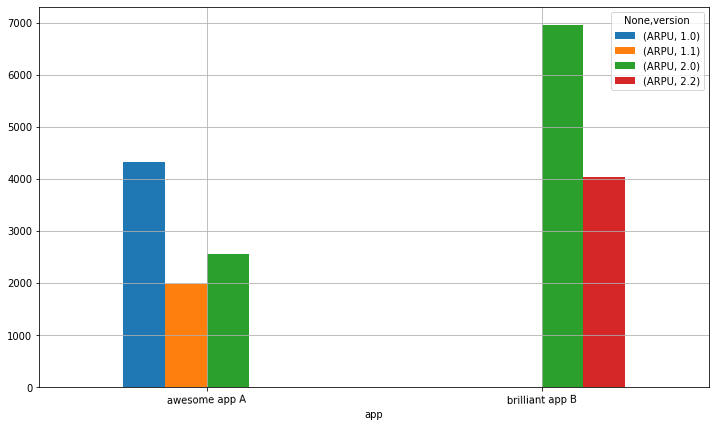

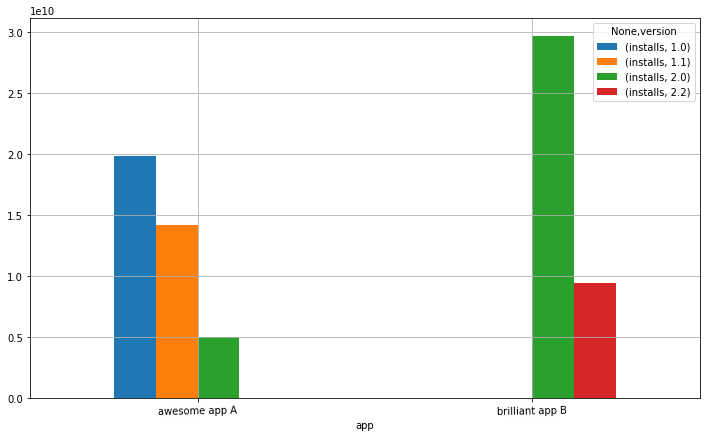

In [ ]:
pd.pivot_table(data_mfi,
              index = 'app',
              columns = ['version'],
              values = ['ARPU'],
              aggfunc = {'ARPU':np.sum}
).plot(kind='bar',
       figsize=(12,7), 
       grid=True, 
       sort_columns=False,
       rot=1
       )
pd.pivot_table(data_mfi,
              index = 'app',
              columns = ['version'],
              values = ['installs'],
              aggfunc = {'installs':np.sum}
).plot(kind='bar',
       figsize=(12,7), 
       grid=True, 
       sort_columns=False,
       rot=1
       )

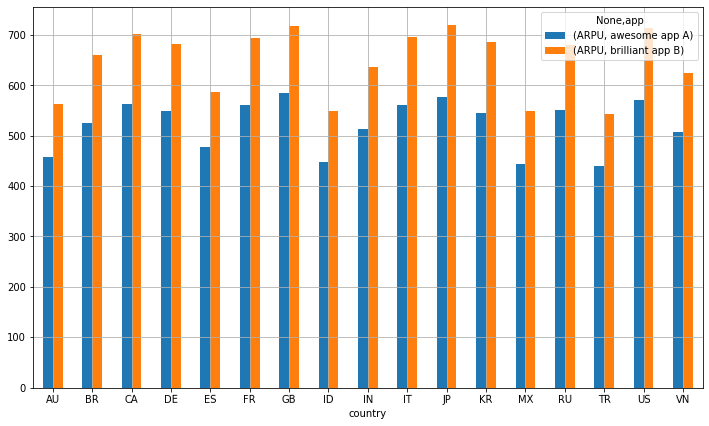

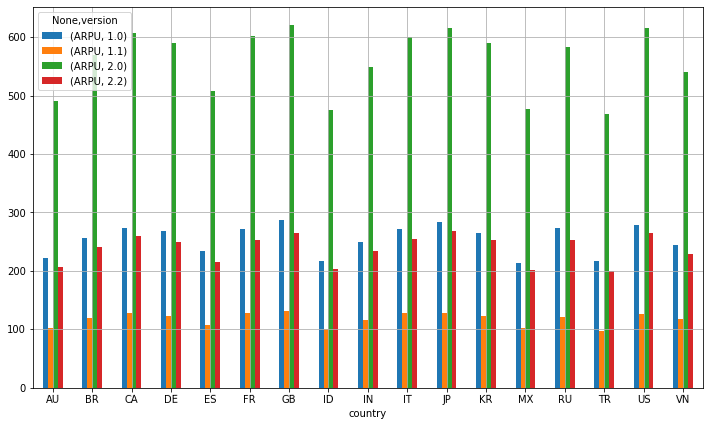

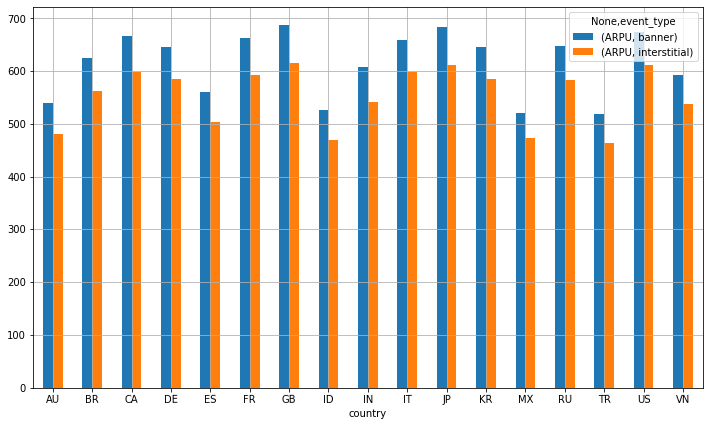

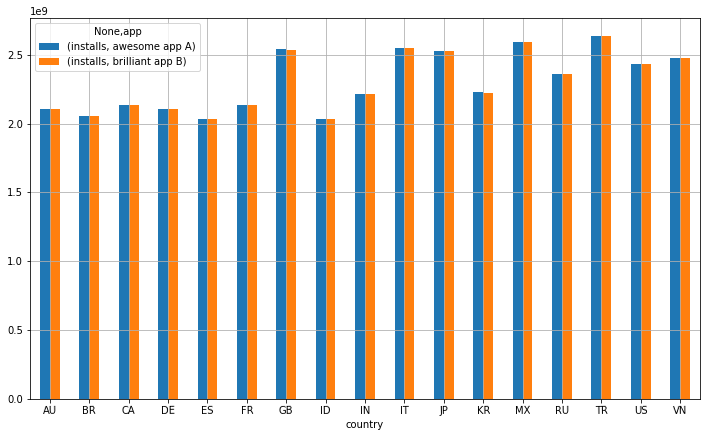

In [ ]:
pd.pivot_table(data_mfi,
              index = 'country',
              columns = ['app'],
              values = ['ARPU'],
              aggfunc = {'ARPU':np.sum}
).plot(kind='bar',
       figsize=(12,7), 
       grid=True, 
       sort_columns=False,
       rot=1  )

pd.pivot_table(data_mfi,
              index = 'country',
              columns = ['version'],
              values = ['ARPU'],
              aggfunc = {'ARPU':np.sum}
).plot(kind='bar',
       figsize=(12,7), 
       grid=True, 
       sort_columns=False,
       rot=1 )

pd.pivot_table(data_mfi,
              index = 'country',
              columns = ['event_type'],
              values = ['ARPU'],
              aggfunc = {'ARPU':np.sum}
).plot(kind='bar',
       figsize=(12,7), 
       grid=True, 
       sort_columns=False,
       rot=1)

pd.pivot_table(data_mfi,
              index = 'country',
              columns = ['app'],
              values = ['installs'],
              aggfunc = {'installs':np.sum}
).plot(kind='bar',
       figsize=(12,7), 
       grid=True, 
       sort_columns=False,
       rot=1   )

In [ ]:
data_mfi[data_mfi.country=='JP'].ARPU.sum()

1295.5855441124309

In [ ]:
data_mfi[data_mfi.country=='US'].ARPU.sum()

1285.6583400138531

In [ ]:
data_mfi[data_mfi.country=='GB'].ARPU.sum()

1302.5274655260935

In [ ]:
data_mfi[data_mfi.country=='AU'].ARPU.sum()

1021.0802764962096

In [ ]:
data_mfi[data_mfi.country=='ID'].ARPU.sum()

996.2457613928921

In [ ]:
data_mfi[data_mfi.country=='MX'].ARPU.sum()

992.7998961344746

In [ ]:
data_mfi[data_mfi.country=='TR'].ARPU.sum()

982.4119314861534

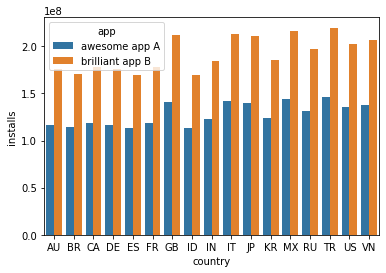

In [ ]:
sns.barplot(
    x="country", 
    y="installs", 
    hue="app", 
    ci=None,
    data=data_mfi
)

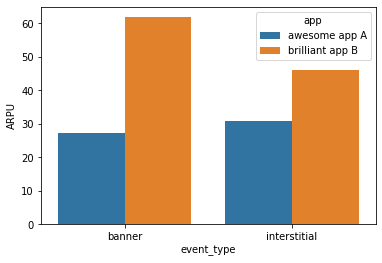

In [ ]:

sns.barplot(
    x="event_type", 
    y="ARPU", 
    hue="app", 
    ci=None,
    data=data_mfi
)

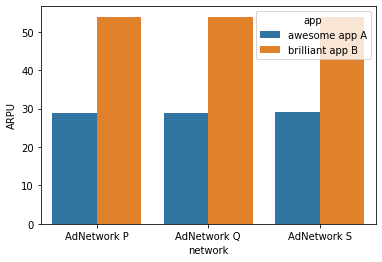

In [ ]:
sns.barplot(
    x="network", 
    y="ARPU", 
    hue="app", 
    ci=None,
    data=data_mfi
)

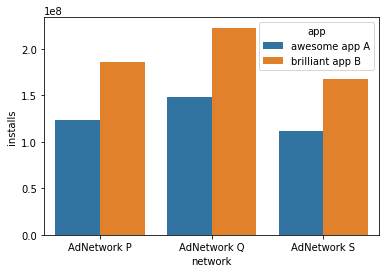

In [ ]:
sns.barplot(
    x="network", 
    y="installs", 
    hue="app", 
    ci=None,
    data=data_mfi
)

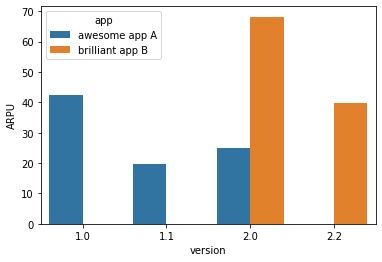

In [ ]:
sns.barplot(
    x="version", 
    y="ARPU", 
    hue="app", 
    ci=None,
    data=data_mfi
)

<BarContainer object of 18360 artists>

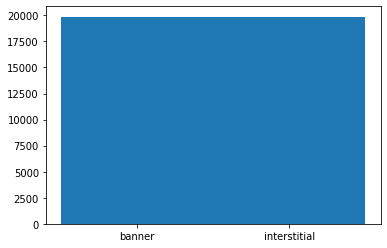

In [ ]:
plt.bar(
    x=data_m_s.event_type, 
    height=data_m_s.ARPU.sum(),
    width=1   
)

In [1]:
sns.barplot(
    x=data_m_s.event_type, 
    y=data_m_s.ARPU.sum(), 
    hue=data_m_s.app, 
    ci=None
)

NameError: ignored

In [ ]:
data_m_s.event_type

0              banner
1              banner
2              banner
3              banner
4              banner
             ...     
18355    interstitial
18356    interstitial
18357    interstitial
18358    interstitial
18359    interstitial
Name: event_type, Length: 18360, dtype: object

In [ ]:
data_m_s.ARPU.sum()

19872.968614974372

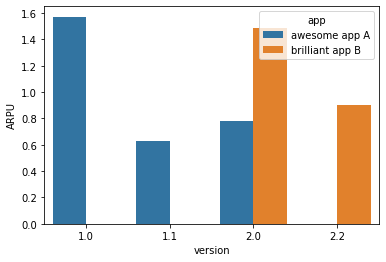

In [ ]:
sns.barplot(
    x="version", 
    y="ARPU", 
    hue="app", 
    ci=None,
    data=data_m_s
)

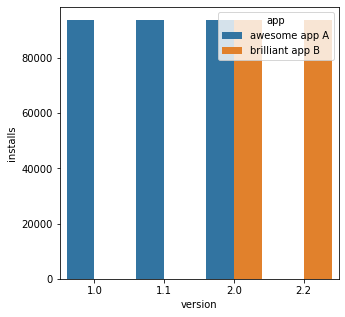

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(
    x="version", 
    y="installs", 
    hue="app", 
    ci=None,
    data=data_m_s
)

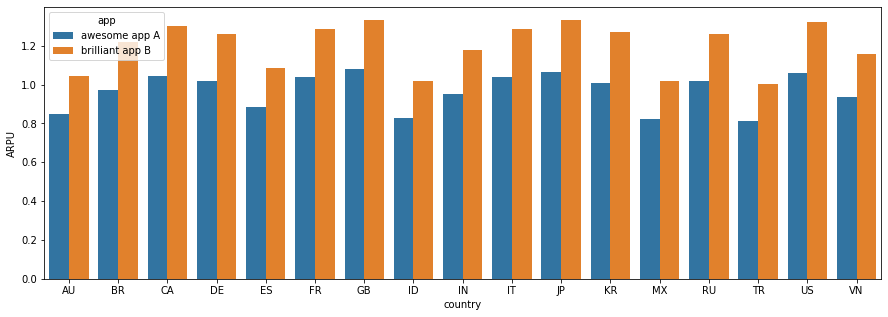

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(
    x="country", 
    y="ARPU", 
    hue="app", 
    ci=None,
    data=data_m_s
)

In [ ]:
sns.barplot(
    x="app", 
    y="ARPU", 
    hue="app", 
    ci=None,
    data=data_m_s
)

https://app2top.ru/marketing/pokazateli-e-ffektivnosti-igr-nakopitel-ny-j-arpu-102795.html

https://habr.com/ru/post/416599/

In [ ]:
data_m['ecpm_value']/1000 data_m['installs']

0         0.000118
1         0.000118
2         0.000119
3         0.000118
4         0.000118
            ...   
835375    0.000096
835376    0.000127
835377    0.000008
835378    0.000006
835379    0.000009
Length: 835380, dtype: float64

In [ ]:
data_m['arpu']

Усппех! 
Мы создали итоговую таблицу с которой и будем дальше работать!)

p.s. было потно но я много чего подчерпнул)

мысли:

- после длительного использования пользователи меньше смотрят рекламы
- в зависемости от версия приложения пользователи меньше его используют 
- в разных странах популярны разные версии приложений

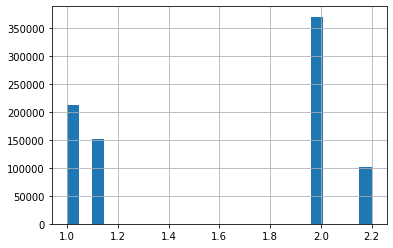

In [ ]:
data_m['version'].hist(bins=25) 

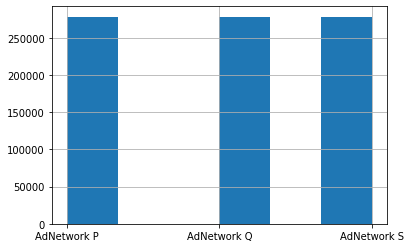

In [ ]:
data_m['network'].hist(bins=6)

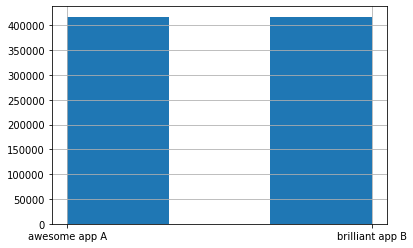

In [ ]:
data_m['app'].hist(bins=3) 

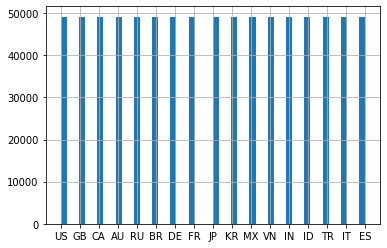

In [ ]:
data_m['country'].hist(bins=50) 

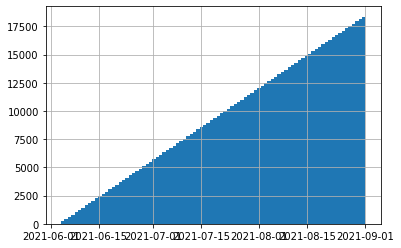

In [ ]:
data_m['actual_date'].hist(bins=90)  

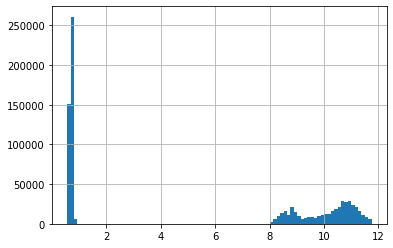

In [ ]:
data_m['ecpm_value'].hist(bins=90)   

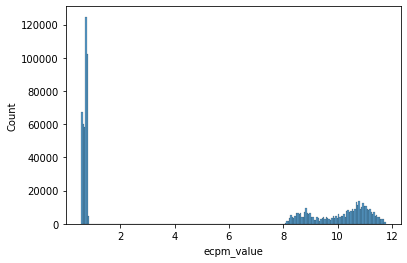

In [ ]:
sns.histplot(data=data_m, x="ecpm_value", binwidth=0.05)

In [ ]:
data_m.head()

,Unnamed: 0,date,app,version,network,event_type,installs,days_after_installs,country,events_amount,day,actual_date,ecpm_value
0,0,2021-06-30 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95897,0,US,757128.0,2021-06-30 14:25:35.063117,2021-06-30,11.344681
1,1,2021-06-29 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95792,1,US,635731.0,2021-06-30 14:25:35.063117,2021-06-30,11.344681
2,2,2021-06-28 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95542,2,US,624999.0,2021-06-30 14:25:35.063117,2021-06-30,11.344681
3,3,2021-06-27 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,95896,3,US,675012.0,2021-06-30 14:25:35.063117,2021-06-30,11.344681
4,4,2021-06-26 14:25:35.063117,awesome app A,1.0,AdNetwork P,interstitial,96081,4,US,466941.0,2021-06-30 14:25:35.063117,2021-06-30,11.344681


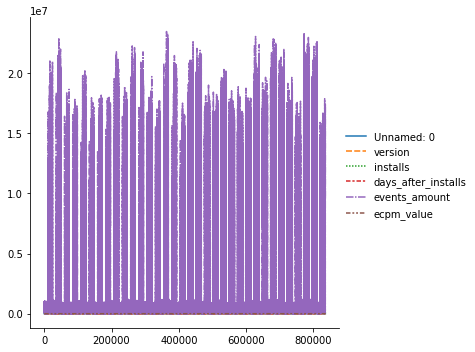

In [ ]:
sns.relplot(
    data=data_m, kind="line"
)

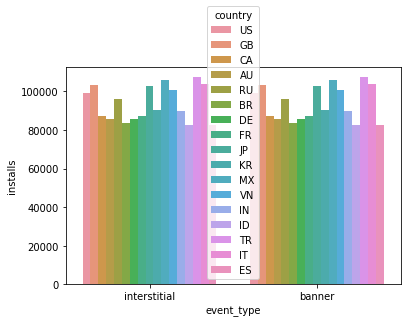

In [ ]:
sns.barplot(
    x="event_type", 
    y="installs", 
    hue="country", 
    ci=None,
    data=data_m
)

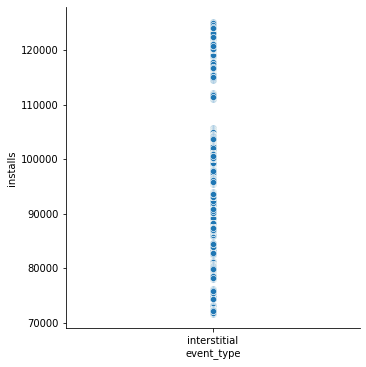

In [ ]:
sns.relplot(x=data_m[data_m.event_type=='interstitial'].event_type, y=data_m.installs)